## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

## 2. Loading Dataset

In [2]:
df_real=pd.read_csv('BuzzFeed_real_news_content.csv')

In [3]:
df_real.shape

(91, 12)

In [4]:
df_fake=pd.read_csv('BuzzFeed_fake_news_content.csv')

In [5]:
df_fake.shape

(91, 12)

First, we need to combine these two dataframes into a single dataframe and create a new variable type which contains the news type as real or fake.

In [6]:
df=pd.concat([df_real,df_fake],axis=0)

In [7]:
df.shape

(182, 12)

In [8]:
df['news_type']=df['id'].apply(lambda x: x.split('_')[0])

In [9]:
df.head(2)

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",Real
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",Real


In [10]:
df.shape

(182, 13)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 90
Data columns (total 13 columns):
id                182 non-null object
title             182 non-null object
text              182 non-null object
url               174 non-null object
top_img           172 non-null object
authors           141 non-null object
source            174 non-null object
publish_date      133 non-null object
movies            25 non-null object
images            172 non-null object
canonical_link    170 non-null object
meta_data         182 non-null object
news_type         182 non-null object
dtypes: object(13)
memory usage: 19.9+ KB


In [12]:
df.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
count,182,182,182,174,172,141,174,133,25,172,170,182,182
unique,182,178,178,171,166,90,27,118,25,169,168,171,2
top,Fake_65-Webpage,CNN’s Post-Debate Rigged Poll Busted…Here Are ...,Back when the news first broke about the pay-t...,http://www.proudcons.com/clinton-foundation-ca...,http://static.politico.com/da/f5/44342c424c68b...,Terresa Monroe-hamilton,http://politi.co,{'$date': 1474588800000},http://www.youtube.com/embed/XcBbguk05D0?versi...,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36847/clinton-foundatio...,{},Real
freq,1,2,2,2,3,8,32,5,1,2,2,8,91


## 3. Data Cleaning and Feature Engineering

We select variables of our interest only for analysis, including title, text, source, movies, images and news_type, and remove other columns.

In [13]:
df.drop(['id','url', 'top_img','authors','publish_date','canonical_link','meta_data'],axis=1, inplace=True)

We create a Series that displays the total count of missing values per column.

In [14]:
df.isnull().sum()

title          0
text           0
source         8
movies       157
images        10
news_type      0
dtype: int64

We convert this Series to be in term of percentage of the total DataFrame.

In [15]:
(df.isnull().sum())/(df.shape[0])*100

title         0.000000
text          0.000000
source        4.395604
movies       86.263736
images        5.494505
news_type     0.000000
dtype: float64

The datset does not contain null values in text and news_type columns which are the most important columns for us. We leave the null values in the source column as is. However, we add a new columns to the data frame which show whether the news are accompanied by movies and/or images or not.

In [16]:
df['contain_movies']=df['movies'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [17]:
df['contain_images']=df['images'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [18]:
df.drop(['movies','images'],axis=1,inplace=True)

In [19]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1


## 4. EDA

### 4.1. Real Versus Fake News Source Analysis

#### 4.1.1. Sources of Publising Real News

In [20]:
real_order=df[df['news_type']=='Real']['source'].value_counts().sort_values(ascending=False).index

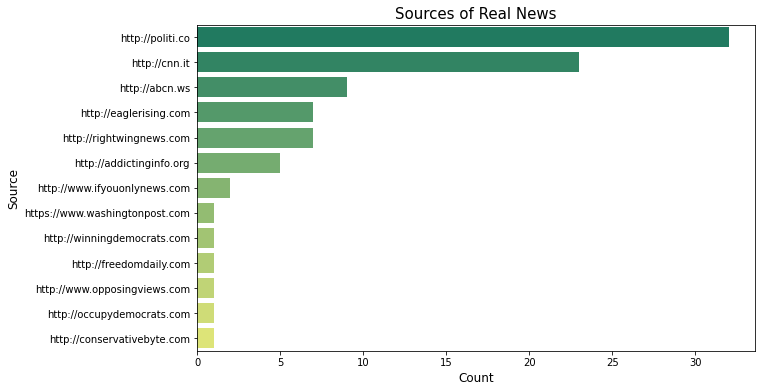

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=df[df['news_type']=='Real'],order=real_order,palette='summer')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

From the above plot we observe that the politi.co reports maximum real news followed by cnn.it with a count of 32 and 23, respectively.

#### 4.1.2. Sources of Publishing Maximum Fake News

In [22]:
fake_order=df[df['news_type']=='Fake']['source'].value_counts().sort_values(ascending=False).index

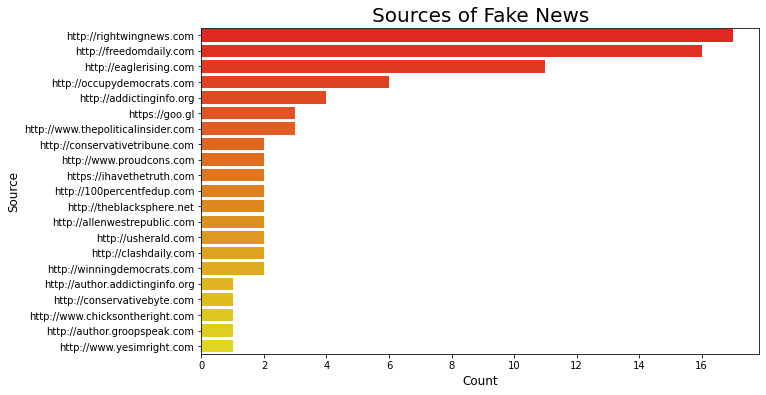

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(y='source',data=df[df['news_type']=='Fake'],order=fake_order,palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=20)
plt.show()

Above plot shows that the rightwingsnews reports maximum fakenews with a count of 17. Also, the number of fake news sources are more than the number of real news sources.

#### 4.1.3. Common Sources of Publishing Both Real and Fake News

In [24]:
new=[]
for x in df[df['news_type']=='Fake']['source'].unique():
    if x in df[df['news_type']=='Real']['source'].unique():
        new.append(x)
print(new)

['http://addictinginfo.org', 'http://eaglerising.com', 'http://conservativebyte.com', 'http://winningdemocrats.com', 'http://freedomdaily.com', 'http://occupydemocrats.com', 'http://rightwingnews.com']


In [25]:
df['common']=df['source'].apply(lambda x: x if x in new else 0)

In [26]:
df1=df[df['common']!=0]

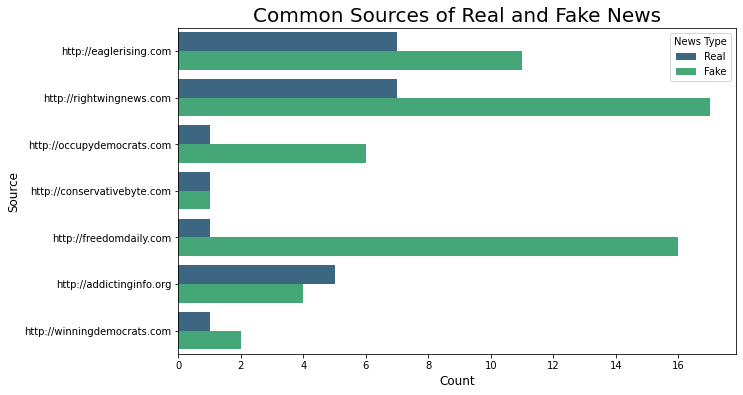

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(y='common',data=df1,hue='news_type',palette='viridis')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

There are 7 common sources of real and fake news. This is interesting that the fake news are more reported by these sources as compared to real news. The rightwingnews reports maximum fake news but it also reports some real news. Approximaltely, two third of total news reported by rightwings are fake. On the other hand, the freedomdaily which is the second largest fake news reporting source, barely reports the real news. addictinginfo.org is the only single common source which reports real news more than fake news but the total number of the news it reports is very low.

#### 4.1.4. Sources Including Movies in the News 

In [28]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images,common
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1,http://eaglerising.com
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1,0


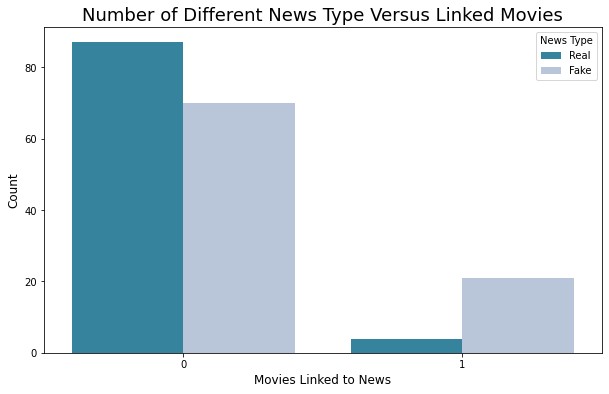

In [29]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_movies', data=df, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Movies Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Movies',fontsize=18)
plt.show()

From the above plot, we observe that most of the news are reported without including the movie clips, and there are very little articles which includes movie clips. This variable does not provide much useful information in our analysis.

#### 4.1.5. Sources Including Images in the News 

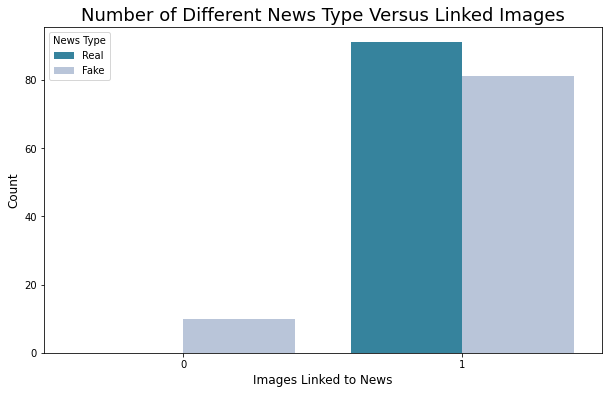

In [30]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_images', data=df, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Images Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='upper left', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Images',fontsize=18)
plt.show()

From the above plot we observe that all the real news sources included images in their articles. We may say that images acts as a proof of thier news. Therefore, this variable reveal that images are an important part of real news articles. The images and movies variables do not give us much details to strenghen our analysis.

### 4.2. Analysis of Title and Body of News Articles

#### 4.2.1. Preprocessing Function

We define a preprocessing function that performs the following operations:

- Converting text to lower case

- Removing numbers from the text corpus

- Removing punctuation from the text corpus

- Removing special characters such as ‘<’, ‘…’ from the text corpus

- Removing english stopwords

- Stemming words to root words

- Removing extra whitespaces from the text corpus

In [31]:
ps=PorterStemmer()
wst= WhitespaceTokenizer() 

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x): 
    new=""
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation 
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces 
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

#### 4.2.2. Analysis of News Title 

We use 'final' function to process the title of news articles, then select the top 20 most frequent words in the news title for both categories i.e., real news and fake news. We plot the term frequency of these words in both categories.

##### 4.2.2.1. Fake News

In [32]:
df_fake=df[df['news_type']=='Fake']

In [33]:
cv1 = CountVectorizer(analyzer=final)
cv1.fit(df_fake['title'])
bow1=cv1.transform(df_fake['title'])

In [34]:
pd.DataFrame(bow1.todense()).shape

(91, 459)

In [35]:
new1=[]
for x in range(0,459):
    new1.append(cv1.get_feature_names()[x])

In [36]:
matrix1=pd.DataFrame(bow1.todense(),columns=new1)

In [37]:
sm1=[]
for x in new1:
    sm1.append(matrix1[x].sum())

In [38]:
trans1=matrix1.transpose()

In [39]:
trans1['sum']=sm1

In [40]:
top1=trans1.sort_values(by='sum', ascending=False).head(20)

##### 4.2.2.2. Real News

In [41]:
df_real=df[df['news_type']=='Real']

In [42]:
cv2 = CountVectorizer(analyzer=final)
cv2.fit(df_real['title'])
bow2=cv2.transform(df_real['title'])

In [43]:
pd.DataFrame(bow2.todense()).shape

(91, 436)

In [44]:
new2=[]
for x in range(0,436):
    new2.append(cv2.get_feature_names()[x])

In [45]:
matrix2=pd.DataFrame(bow2.todense(),columns=new2)

In [46]:
sm2=[]
for x in new2:
    sm2.append(matrix2[x].sum())

In [47]:
trans2=matrix2.transpose()

In [48]:
trans2['sum']=sm2

In [49]:
top2=trans2.sort_values(by='sum', ascending=False).head(20)

##### 4.2.2.3. Concatenation

In [50]:
top1.drop(list(range(0,91)),axis=1,inplace=True)

In [51]:
top1['type']=['Fake']*20

In [52]:
top2.drop(list(range(0,91)),axis=1,inplace=True)

In [53]:
top2['type']=['Real']*20

In [54]:
conc1=pd.concat([top1,top2])

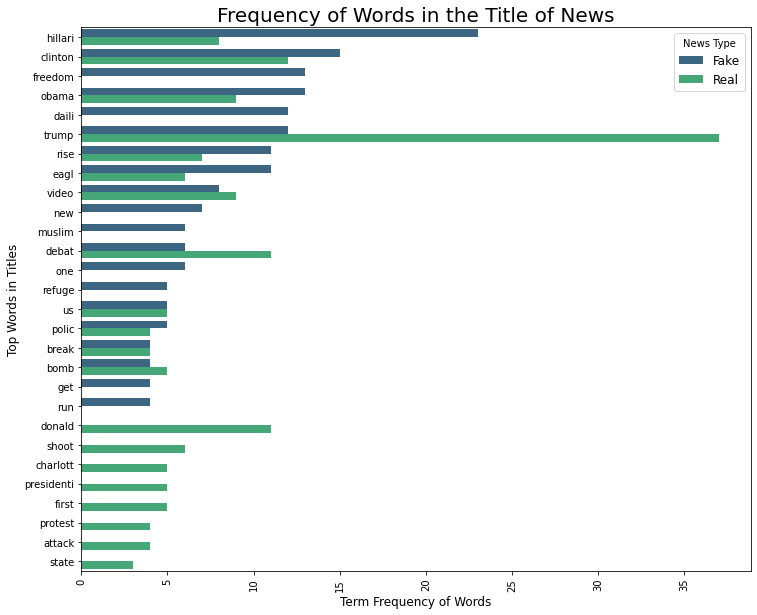

In [55]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc1.index,x='sum',data=conc1,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News',fontsize=20)
plt.show()

The term frequency plot shows that some words like hillari, clinton, freedom and obama are representative of the title of fake news whereas words like trump, clinton, donald and debat are representative of the title of real news.

#### 4.2.3. Analysis of News Body

After analyzing the title, we analyze the text body of the news articles. We are interested in finding top 30 representative words in the body of fake news and real news. We perform same steps by calling "final" function on the body of the news article, and then select the top 30 most frequent words in the news title for both categories i,e. real news and fake news. We plot the term frequency of such words in both categories i.e., real news and fake news. We plot these words to visualise the high frequency words associated with fake and real news.

##### 4.2.3.1. Fake News

In [56]:
cv3 = CountVectorizer(analyzer=final)
cv3.fit(df_fake['text'])
bow3=cv3.transform(df_fake['text'])

In [57]:
pd.DataFrame(bow3.todense()).shape

(91, 4958)

In [58]:
new3=[]
for x in range(0,4958):
    new3.append(cv3.get_feature_names()[x])

In [59]:
matrix3=pd.DataFrame(bow3.todense(),columns=new3)

In [60]:
sm3=[]
for x in new3:
    sm3.append(matrix3[x].sum())

In [61]:
trans3=matrix3.transpose()

In [62]:
trans3['sum']=sm3

In [63]:
top3=trans3.sort_values(by='sum', ascending=False).head(30)

##### 4.2.3.2. Real News

In [64]:
cv4 = CountVectorizer(analyzer=final)
cv4.fit(df_real['text'])
bow4=cv4.transform(df_real['text'])

In [65]:
pd.DataFrame(bow4.todense()).shape

(91, 6529)

In [66]:
new4=[]
for x in range(0,6529):
    new4.append(cv4.get_feature_names()[x])

In [67]:
matrix4=pd.DataFrame(bow4.todense(),columns=new4)

In [68]:
sm4=[]
for x in new4:
    sm4.append(matrix4[x].sum())

In [69]:
trans4=matrix4.transpose()

In [70]:
trans4['sum']=sm4

In [71]:
top4=trans4.sort_values(by='sum', ascending=False).head(30)

##### 4.2.3.3. Concatenation

In [72]:
top3.drop(list(range(0,91)),axis=1,inplace=True)

In [73]:
top3['type']=['Fake']*30

In [74]:
top4.drop(list(range(0,91)),axis=1,inplace=True)

In [75]:
top4['type']=['Real']*30

In [76]:
conc2=pd.concat([top3,top4])

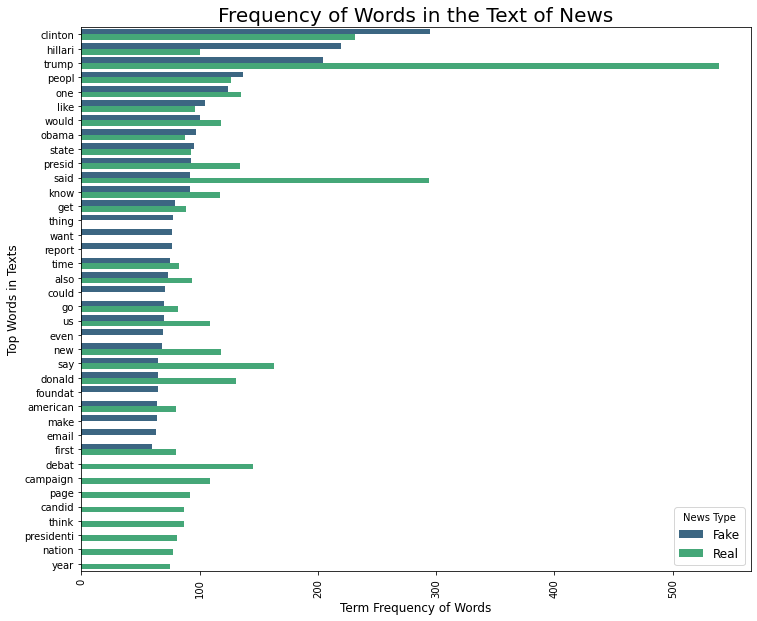

In [77]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc2.index,x='sum',data=conc2,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Texts',fontsize=12)
plt.legend(title='News Type',fontsize=12,loc='lower right')
plt.title('Frequency of Words in the Text of News',fontsize=20)
plt.show()

From the above plot, we notice that words like trump and clinton are the most frequent words in the news body.
The term frequency plot shows that some words like clinton, hillari and trump are representative of fake news whereas words like trump, said, clinton are representative of real news.

#### 4.2.4. Analysis of Title Length

After the analysis on the words in the title and body of news, we want to know that whether the title length is also a discriminatory feature/factor between fake and real news category.

In [78]:
df['title_length']=df['title'].apply(lambda x: len(x))

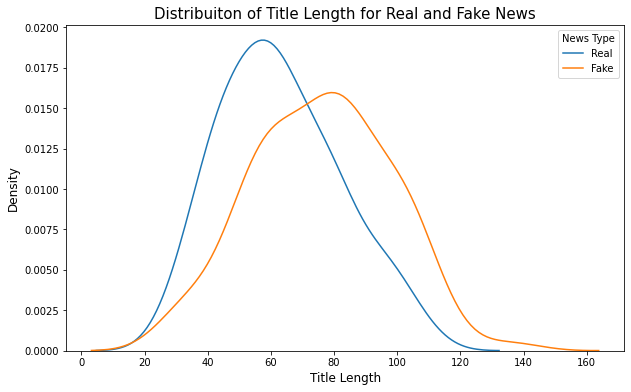

In [79]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['news_type']=='Real']['title_length'])
sns.kdeplot(df[df['news_type']=='Fake']['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Title Length for Real and Fake News',fontsize=15)
plt.show()

The title length of fake news is slighly larger than the real news. Real news title length distribution is centered with the maximum density at the length of 60, while the center of distribution of title length for fake news is slightly skewed  with the maximum density at the length of 80.

## 5. Fake/Real News Classification

In this part, we build three different classifiers that classfies the news as Real or Fake as follows:

- 1. The outcome variable is the news category and the features are terms used in the body of the news article. 

- 2. The outcome variable is the news category and the features are terms used in the title of the news article.

- 3. The outcome variable is the news category and the features are combined terms used in the title and body of the news article.

### 5.1. Fake/Real News Detection Based on News Body

#### 5.1.1. plitting Data into Train and Test Datasets 

In [80]:
X1=df['text']
y1=df['news_type']

In [81]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

#### 5.1.2. Random Forest Classifier with Text Preprocessing

In [82]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [83]:
pp.fit(X1_train,y1_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [84]:
predictions1=pp.predict(X1_test)

In [85]:
print(confusion_matrix(y1_test, predictions1))
print('\n')
print(classification_report(y1_test, predictions1))

[[14 12]
 [10 19]]


              precision    recall  f1-score   support

        Fake       0.58      0.54      0.56        26
        Real       0.61      0.66      0.63        29

    accuracy                           0.60        55
   macro avg       0.60      0.60      0.60        55
weighted avg       0.60      0.60      0.60        55



The accuracy of Random Forest Classifier on body with preprocessing is only 60% which means that there are only 60% of news in the test dataset that the classifier predicts correctly. To improve accuracy, we train this model on body without preprocessing.

#### 5.1.3. Random Forest Classifier Without Text Preprocessing

In [86]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [87]:
pp.fit(X1_train,y1_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [88]:
predictions2=pp.predict(X1_test)

In [89]:
print(confusion_matrix(y1_test, predictions2))
print('\n')
print(classification_report(y1_test, predictions2))

[[19  7]
 [16 13]]


              precision    recall  f1-score   support

        Fake       0.54      0.73      0.62        26
        Real       0.65      0.45      0.53        29

    accuracy                           0.58        55
   macro avg       0.60      0.59      0.58        55
weighted avg       0.60      0.58      0.57        55



The accuracy of Random Forest Classifier on body without preprocessing is still 58%. To improve accuracy we train another model.

#### 5.1.4. Naive Bayes Classifier with Text Preprocessing

In [90]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [91]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose

In [92]:
predictions3=pp.predict(X1_test)

In [93]:
print(confusion_matrix(y1_test, predictions3))
print('\n')
print(classification_report(y1_test, predictions3))

[[22  4]
 [13 16]]


              precision    recall  f1-score   support

        Fake       0.63      0.85      0.72        26
        Real       0.80      0.55      0.65        29

    accuracy                           0.69        55
   macro avg       0.71      0.70      0.69        55
weighted avg       0.72      0.69      0.69        55



The accuracy of Naive Bayes Classifier on body with preprocessing is 69%. To improve accuracy, we train this model without preprocessing.

#### 5.1.5. Naive Bayes Classifier without Text Preprocessing

In [94]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [95]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [96]:
predictions4=pp.predict(X1_test)

In [97]:
print(confusion_matrix(y1_test, predictions4))
print('\n')
print(classification_report(y1_test, predictions4))

[[25  1]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.60      0.96      0.74        26
        Real       0.92      0.41      0.57        29

    accuracy                           0.67        55
   macro avg       0.76      0.69      0.65        55
weighted avg       0.77      0.67      0.65        55



The accuracy of Naive Bayes Classifier decreases to 67% on body without preprocessing.To improve accuracy, we train another model.

#### 5.1.6. Passive Aggressive Classifier with Text Preprocessing

In [98]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [99]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [100]:
predictions5=pp.predict(X1_test)

In [101]:
print(confusion_matrix(y1_test, predictions5))
print('\n')
print(classification_report(y1_test, predictions5))

[[21  5]
 [ 5 24]]


              precision    recall  f1-score   support

        Fake       0.81      0.81      0.81        26
        Real       0.83      0.83      0.83        29

    accuracy                           0.82        55
   macro avg       0.82      0.82      0.82        55
weighted avg       0.82      0.82      0.82        55



The accuracy of Passive Aggressive Classifier on body with preprocessing is 82%. To improve accuracy, we train this model without preprocessing.

#### 5.1.7. Passive Aggressive Classifier without Text Preprocessing

In [102]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [103]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [104]:
predictions6=pp.predict(X1_test)

In [105]:
print(confusion_matrix(y1_test, predictions6))
print('\n')
print(classification_report(y1_test, predictions6))

[[22  4]
 [ 5 24]]


              precision    recall  f1-score   support

        Fake       0.81      0.85      0.83        26
        Real       0.86      0.83      0.84        29

    accuracy                           0.84        55
   macro avg       0.84      0.84      0.84        55
weighted avg       0.84      0.84      0.84        55



The accuracy of Passive Aggressive Classifier increases to 84% on body without preprocessing.

### 5.2. Fake/Real News Detection Based on News Title

#### 5.2.1. Splitting Data into Train and Test Datasets 

In [106]:
X2=df['title']
y2=df['news_type']

In [107]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

#### 5.2.2. Random Forest Classifier with Text Preprocessing

In [108]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [109]:
pp.fit(X2_train,y2_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [110]:
predictions7=pp.predict(X2_test)

In [111]:
print(confusion_matrix(y2_test, predictions7))
print('\n')
print(classification_report(y2_test, predictions7))

[[16 10]
 [11 18]]


              precision    recall  f1-score   support

        Fake       0.59      0.62      0.60        26
        Real       0.64      0.62      0.63        29

    accuracy                           0.62        55
   macro avg       0.62      0.62      0.62        55
weighted avg       0.62      0.62      0.62        55



The accuracy of Random Forest Classifier on title is 62%. To improve accuracy, we train this model without preprocessing.

#### 5.2.3. Random Forest Classifier without Text Preprocessing

In [112]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [113]:
pp.fit(X2_train,y2_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [114]:
predictions8=pp.predict(X2_test)

In [115]:
print(confusion_matrix(y2_test, predictions8))
print('\n')
print(classification_report(y2_test, predictions8))

[[20  6]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.57      0.77      0.66        26
        Real       0.70      0.48      0.57        29

    accuracy                           0.62        55
   macro avg       0.64      0.63      0.61        55
weighted avg       0.64      0.62      0.61        55



The accuracy of Random Forest Classifier on title is 62% on title without preprocessing.To improve accuracy, we train another model.

#### 5.2.4. Naive Bayes Classifier with Text Preprocessing

In [116]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [117]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose

In [118]:
predictions9=pp.predict(X2_test)

In [119]:
print(confusion_matrix(y2_test, predictions9))
print('\n')
print(classification_report(y2_test, predictions9))

[[21  5]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.55      0.81      0.66        26
        Real       0.71      0.41      0.52        29

    accuracy                           0.60        55
   macro avg       0.63      0.61      0.59        55
weighted avg       0.63      0.60      0.59        55



The accuracy of Naive Bayes classifier on title with preprocessing is 60%. To improve accuracy, we train we train this model on title without preprocessing.

#### 5.2.5. Naive Bayes Classifier without Text Preprocessing

In [120]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [121]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [122]:
predictions10=pp.predict(X2_test)

In [123]:
print(confusion_matrix(y2_test, predictions10))
print('\n')
print(classification_report(y2_test, predictions10))

[[22  4]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.54      0.85      0.66        26
        Real       0.71      0.34      0.47        29

    accuracy                           0.58        55
   macro avg       0.63      0.60      0.56        55
weighted avg       0.63      0.58      0.56        55



The accuracy of Naive Bayes Classifier on title is reduced to 58% on title without preprocessing.To improve accuracy, we train another model.

#### 5.2.6. Passive Aggressive Classifier with Text Preprocessing

In [124]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [125]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [126]:
predictions11=pp.predict(X2_test)

In [127]:
print(confusion_matrix(y2_test, predictions11))
print('\n')
print(classification_report(y2_test, predictions11))

[[19  7]
 [16 13]]


              precision    recall  f1-score   support

        Fake       0.54      0.73      0.62        26
        Real       0.65      0.45      0.53        29

    accuracy                           0.58        55
   macro avg       0.60      0.59      0.58        55
weighted avg       0.60      0.58      0.57        55



The accuracy of Passive Aggressive Classifier on title with preprocessing is 58%. To improve accuracy, we train this model without preprocessing.

#### 5.2.7. Passive Aggressive Classifier without Text Preprocessing

In [128]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [129]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [130]:
predictions12=pp.predict(X2_test)

In [131]:
print(confusion_matrix(y2_test, predictions12))
print('\n')
print(classification_report(y2_test, predictions12))

[[19  7]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.53      0.73      0.61        26
        Real       0.63      0.41      0.50        29

    accuracy                           0.56        55
   macro avg       0.58      0.57      0.56        55
weighted avg       0.58      0.56      0.55        55



The accuracy of Passive Aggressive Classifier decreases to 56% on title without preprocessing.

### 5.3. Fake/Real News Detection Based on Both Body and Title of News 

#### 5.3.1. Splitting Data into Train and Test Datasets 

In [132]:
df['title_text']=df['title']+': ' +df['text']

In [133]:
X3=df['title_text']
y3=df['news_type']

In [134]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

#### 5.3.2. Random Forest Classifier with Text Preprocessing

In [135]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [136]:
pp.fit(X3_train,y3_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [137]:
predictions13=pp.predict(X3_test)

In [138]:
print(confusion_matrix(y3_test, predictions13))
print('\n')
print(classification_report(y3_test, predictions13))

[[17  9]
 [13 16]]


              precision    recall  f1-score   support

        Fake       0.57      0.65      0.61        26
        Real       0.64      0.55      0.59        29

    accuracy                           0.60        55
   macro avg       0.60      0.60      0.60        55
weighted avg       0.61      0.60      0.60        55



The accuracy of Random Forest Classifier on the mixture of title and body is 60%. To improve accuracy, we train this model on the mixture of title and body without preprocessing

#### 5.3.3. Random Forest Classifier without Text Preprocessing

In [139]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [140]:
pp.fit(X3_train,y3_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [141]:
predictions14=pp.predict(X3_test)

In [142]:
print(confusion_matrix(y3_test, predictions14))
print('\n')
print(classification_report(y3_test, predictions14))

[[20  6]
 [12 17]]


              precision    recall  f1-score   support

        Fake       0.62      0.77      0.69        26
        Real       0.74      0.59      0.65        29

    accuracy                           0.67        55
   macro avg       0.68      0.68      0.67        55
weighted avg       0.69      0.67      0.67        55



The accuracy of Random Forest Classifier on the mixture of title and body without preprocessing is 67%. To improve accuracy, we train another model.

#### 5.3.4. Naive Bayes Classifier with Text Preprocessing

In [143]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [144]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose

In [145]:
predictions15=pp.predict(X3_test)

In [146]:
print(confusion_matrix(y3_test, predictions15))
print('\n')
print(classification_report(y3_test, predictions15))

[[22  4]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.59      0.85      0.70        26
        Real       0.78      0.48      0.60        29

    accuracy                           0.65        55
   macro avg       0.69      0.66      0.65        55
weighted avg       0.69      0.65      0.64        55



The accuracy of Naive Bayes classifier on the mixture of title and body is 65%. To improve accuracy, we train this model on the mixture of title and body without preprocessing.

#### 5.3.5. Naive Bayes Classifier without Text Preprocessing

In [147]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [148]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [149]:
predictions16=pp.predict(X3_test)

In [150]:
print(confusion_matrix(y3_test, predictions16))
print('\n')
print(classification_report(y3_test, predictions16))

[[25  1]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.57      0.96      0.71        26
        Real       0.91      0.34      0.50        29

    accuracy                           0.64        55
   macro avg       0.74      0.65      0.61        55
weighted avg       0.75      0.64      0.60        55



The accuracy of Naive Bayes Classifier is reduced to 64% on the mixture of title and body without preprocessing.To improve accuracy, we train another model.

#### 5.3.6. Passive Aggressive Classifier withText Preprocessing

In [151]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [152]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x0000018CF34DD3A8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [153]:
predictions17=pp.predict(X3_test)

In [154]:
print(confusion_matrix(y3_test, predictions17))
print('\n')
print(classification_report(y3_test, predictions17))

[[20  6]
 [10 19]]


              precision    recall  f1-score   support

        Fake       0.67      0.77      0.71        26
        Real       0.76      0.66      0.70        29

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.72      0.71      0.71        55



The accuracy of Passive Aggressive Classifier on the mixture of title and body with preprocessing is 71%. To improve accuracy, we train this model without preprocessing.

#### 5.3.7. Passive Aggressive Classifier without Text Preprocessing

In [155]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [156]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [157]:
predictions18=pp.predict(X3_test)

In [158]:
print(confusion_matrix(y3_test, predictions18))
print('\n')
print(classification_report(y3_test, predictions18))

[[23  3]
 [ 4 25]]


              precision    recall  f1-score   support

        Fake       0.85      0.88      0.87        26
        Real       0.89      0.86      0.88        29

    accuracy                           0.87        55
   macro avg       0.87      0.87      0.87        55
weighted avg       0.87      0.87      0.87        55



The accuracy of Passive Aggressive Classifier increases to 87% on the mixture of title and body without preprocessing.

In [160]:
print('Text_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions1)))
print('Text_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions2)))
print('Text_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions3)))
print('Text_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions4)))
print('Text_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions5)))
print('Text_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions6)))
print('\n')
print('Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions7)))
print('Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions8)))
print('Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions9)))
print('Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions10)))
print('Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions11)))
print('Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions12)))
print('\n')
print('Text&Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions13)))
print('Text&Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions14)))
print('Text&Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions15)))
print('Text&Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions16)))
print('Text&Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions17)))
print('Text&Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions18)))

Text_Random Forest Classifier_With Text Preprocessing:  60.0
Text_Random Forest Classifier_Without Text Preprocessing:  58.0
Text_Naive Bayes Classifier_With Text Preprocessing:  69.0
Text_Naive Bayes Classifier_Without Text Preprocessing:  67.0
Text_Passive Aggressive Classifier_With Text Preprocessing:  82.0
Text_Passive Aggressive Classifier_Without Text Preprocessing:  84.0


Title_Random Forest Classifier_With Text Preprocessing:  62.0
Title_Random Forest Classifier_Without Text Preprocessing:  62.0
Title_Naive Bayes Classifier_With Text Preprocessing:  60.0
Title_Naive Bayes Classifier_Without Text Preprocessing:  58.0
Title_Passive Aggressive Classifier_With Text Preprocessing:  58.0
Title_Passive Aggressive Classifier_Without Text Preprocessing:  56.0


Text&Title_Random Forest Classifier_With Text Preprocessing:  60.0
Text&Title_Random Forest Classifier_Without Text Preprocessing:  67.0
Text&Title_Naive Bayes Classifier_With Text Preprocessing:  65.0
Text&Title_Naive Bayes Cla

We observe that 87% accuracy is obtained on the test dataset for Passive Aggressive Classifier on combined (body & title) feature matrix without text preprocessing. As 84% accuracy is obtained on the test dataset for Passive Aggressive Classifier on text feature without text preprocessing, it seems that combining titles with body improves the accuracy of the model to 87%. Regarding the preprocessing, it should be mentioned that although some phrases and bigrams should be cleaned and preprocessed, removing stop words and stemming might not be a good idea in this specific dataset as we might loose some langauge information.Therefore, we conclude that Passive Aggressive model on the combined feature matrix without text preprocessing is the best classifcation model in our analysis that can categorize the real and fake news with maximum accuracy.

## 6. Conclusion

Analyzing text data is more challenging than numeric data. In this project, the following tasks were preformed:**

* We performed detailed exploratory data analysis on the real and fake news dataset. We generated multiple plots of all variables for both news categories.

* We determined the most frequent words included in the title or body of the fake news and real news.

* We trained binary classifiers that classify fake news and real news on the basis of words in the title, body, or both title and body of the news articles. We used three different classifiers including Random Forest Classifier, Naive-Bayes Classifier and passive Aggressive Classifier. Passive Aggressive was the best model for this analysis on the combined feature matrix without text preprocessing which predicted fake and reals news with 87% accuracy.